In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from collections import Counter
import re
import warnings
warnings.filterwarnings('ignore')

In [2]:
# The data is processed to 4HZ after linear interpolation
# Y represents fetal heart rate
# T represents manual fetal movement
# A represents automatic fetal movement
# O represents uterine contraction

reg = r"\d+\.?\d*"
with open("11.txt") as fin:
    raw = fin.read()
    raw_numbers = re.findall(reg, raw)
    mat = np.reshape(np.array(raw_numbers, dtype=float), (-1, 4))
    hr = mat[:,0]
    t = mat[:,1]

In [3]:
dec_data = pd.read_csv("11.csv")
dec_list = []
for j in range(len(dec_data)):
    d = []
    d.append(int(float(dec_data['begin'][j])*4-1))
    d.append(int(float(dec_data['end'][j])*4-1))
    dec_list.append(d)

In [4]:
def noise_detector(bpm_list):
    """
    SQI: 1 is good, 0 is bad
    """
    if np.mean(bpm_list) > 200 or np.mean(bpm_list) < 80:
        return 0
    elif np.min(bpm_list) < 60:
        return 0
    elif np.max(bpm_list)/np.min(bpm_list) > 1.5:
        return 0
    else:
        return 1

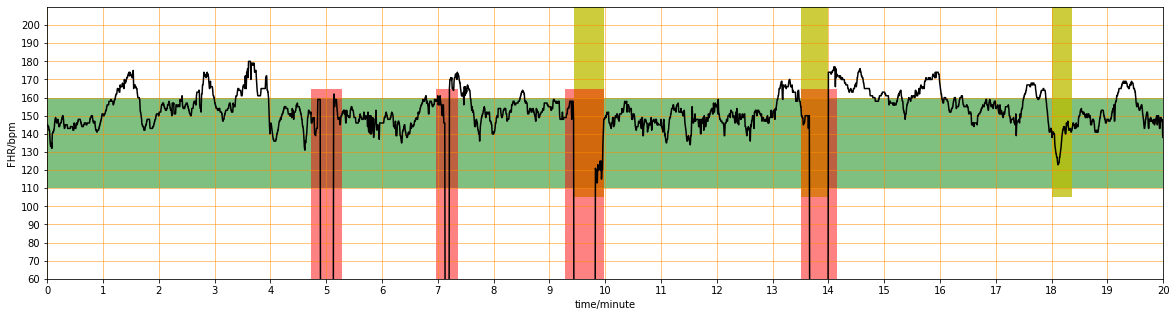

In [5]:
fs = 4
stride = 60*fs
window_size = 60*fs
line = 50
errors = []
mark = 0

fsqi = []
x_list = np.arange(len(t))/fs/60

q_list = []
for i in range(len(x_list)):
    q_list.append(0)
for start_idx in range(0, len(hr)-window_size, fs):
    tmp_hr = hr[start_idx:start_idx+window_size]
    tmp_quality = noise_detector(tmp_hr)
    if tmp_quality == 0:
        for i in range(start_idx, start_idx+window_size):
            q_list[i] = q_list[i] + 1
start = 0
end = 0
for i in range(len(q_list)):
    if (start == 0):
        if (q_list[i] > line):
            start = i
    else:
        if (q_list[i] <= line):
            end = i - 1
            f = []
            f.append(start)
            f.append(end)
            fsqi.append(f)
            start = 0

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1, 1, 1)
plt.plot(x_list, hr, c='k')
plt.xlim([0,20])
plt.ylim([60,210])
plt.axhspan(110, 160, facecolor='green', alpha=0.5)
plt.grid(True, which='both', color='#FF8C00', linewidth=0.5)
plt.xlabel('time/minute')
plt.ylabel('FHR/bpm')
plt.rc('font',family='Times New Roman')

x_ticks = np.arange(0, 21, 1)
y_ticks = np.arange(60, 210, 10)
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)

for dec_events in dec_list:
    start_time = dec_events[0]
    end_time = dec_events[1]
    if (start_time < 0 or start_time >= len(x_list) or end_time >= len(x_list)):
        continue
    for temp in fsqi:
        plt.axvspan(x_list[start_time], x_list[end_time], ymin=0.3, facecolor='y', alpha=0.3)
        plt.axvspan(x_list[temp[0]], x_list[temp[1]], ymax=0.7, facecolor='r', alpha=0.2)